# Определение наиболее выгодного региона нефтедобычи

**Цели исследования:**

По анализу данных о пробах нефти в трёх регионах (0, 1, 2) необходимо дать рекомендации, в каком регионе разрабатывать новые месторождения для получения наибольшей прибыли для добывающей компании «ГлавРосГосНефть»
Для этого нужно построить модель для определения региона, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой Bootstrap.

**Ход исследования:**
               
- Загрузка и подготовка данных для каждого из регионов
- Обучение и проверка модели
    - Разбивка данных на обучающую и валидационную выборки
    - Обучение модели и получение предсказаний на валидационной выборке
    - Получение средних запасов и оценок моделей по метрике RMSE
    - Выводы
- Подготовка и расчёт прибыли
    - Рассчет достаточного объёма сырья для безубыточной разработки новой скважины
    - Рассчет прибыли для лучших месторождений, предсказанных моделью
    - Выводы
- Расчёт прибыли и рисков
    - Расчет рисков и прибыли для каждого региона методом Bootstrap:
- Итоговый вывод

**Итоги исследования:**

- Выяснено, что разработка случайных месторождений в среднем убыточна во всех регионах, выбор сделан в пользу отбора региона, в котором прибыльна разработка "лучших 200" (отобранных моделью) месторождений.
- Определены прибыльные регионы нефтедобычи и уровень риска, определяемый как вероятность того, что разработка будет неприбыльной.
- Рекомендован к разработке регион с максимальной прибылью и уровнем риска меньше критического. 

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [2]:
geo_0 = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/geo_data_2.csv')

### Регион 0, знакомство с данными:

In [3]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Стандартные статистики:

In [5]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Проверка на полные явные дубликаты строк:

In [6]:
geo_0.duplicated().sum()

0

Проверка на неполные явные дубликаты (по столбцу id):

In [7]:
print('Неполные дубликаты:', geo_0['id'].duplicated().sum())

Неполные дубликаты: 10


Устранение дубликатов (по столбцу id):

In [8]:
geo_0 = geo_0.drop_duplicates(subset=['id'])
print('Неполные дубликаты:', geo_0['id'].duplicated().sum())

Неполные дубликаты: 0


Попарный разброс признаков в регионе 0:

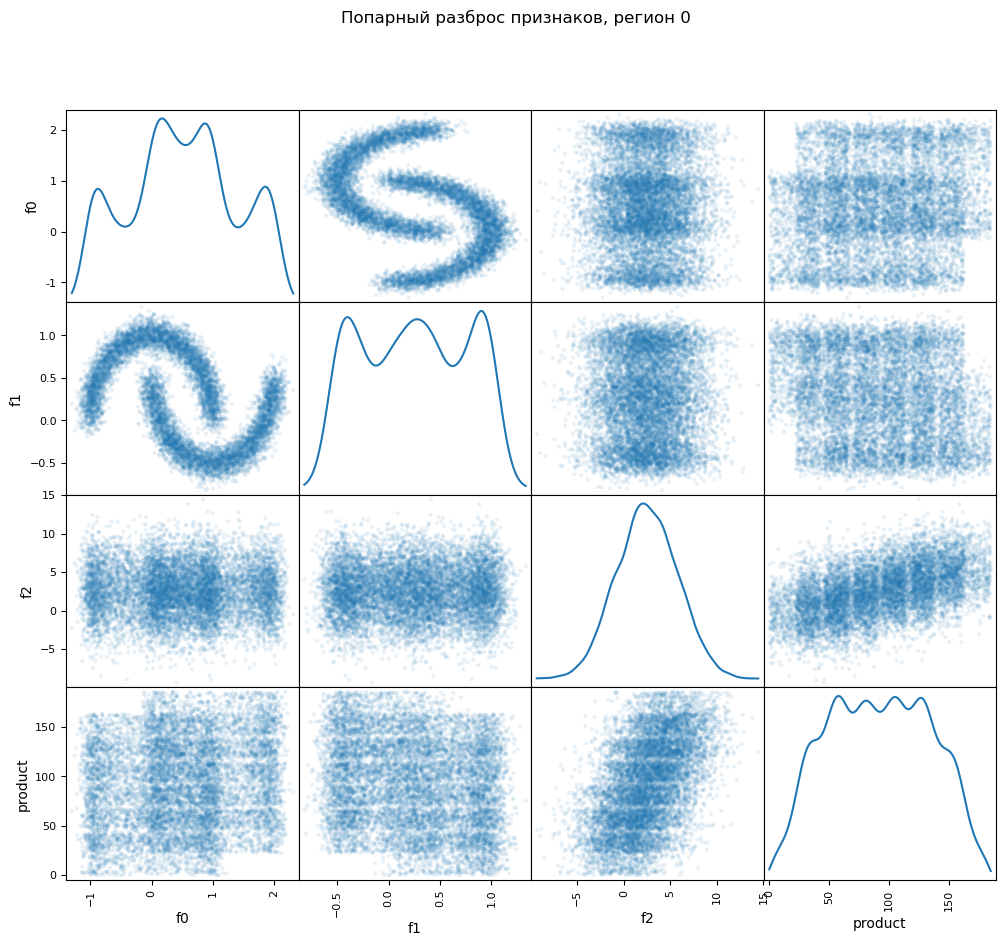

In [9]:
pd.plotting.scatter_matrix(geo_0.sample(frac=0.1), alpha=0.1, figsize=(12, 10), diagonal='kde') 
plt.suptitle('Попарный разброс признаков, регион 0');

Попарная корреляция признаков:

In [10]:
geo_0.drop('id', axis=1).corr().style.background_gradient(cmap='Blues')

,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


### Регион 1, знакомство с данными:

In [11]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Стандартные статистики:

In [13]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Проверка на полные явные дубликаты строк:

In [14]:
geo_1.duplicated().sum()

0

Проверка на неполные явные дубликаты (по столбцу id):

In [15]:
print('Неполные дубликаты:', geo_1['id'].duplicated().sum())

Неполные дубликаты: 4


Устранение дубликатов (по столбцу id):

In [16]:
geo_1 = geo_1.drop_duplicates(subset=['id'])
print('Неполные дубликаты:', geo_1['id'].duplicated().sum())

Неполные дубликаты: 0


Попарный разброс признаков в регионе 1:

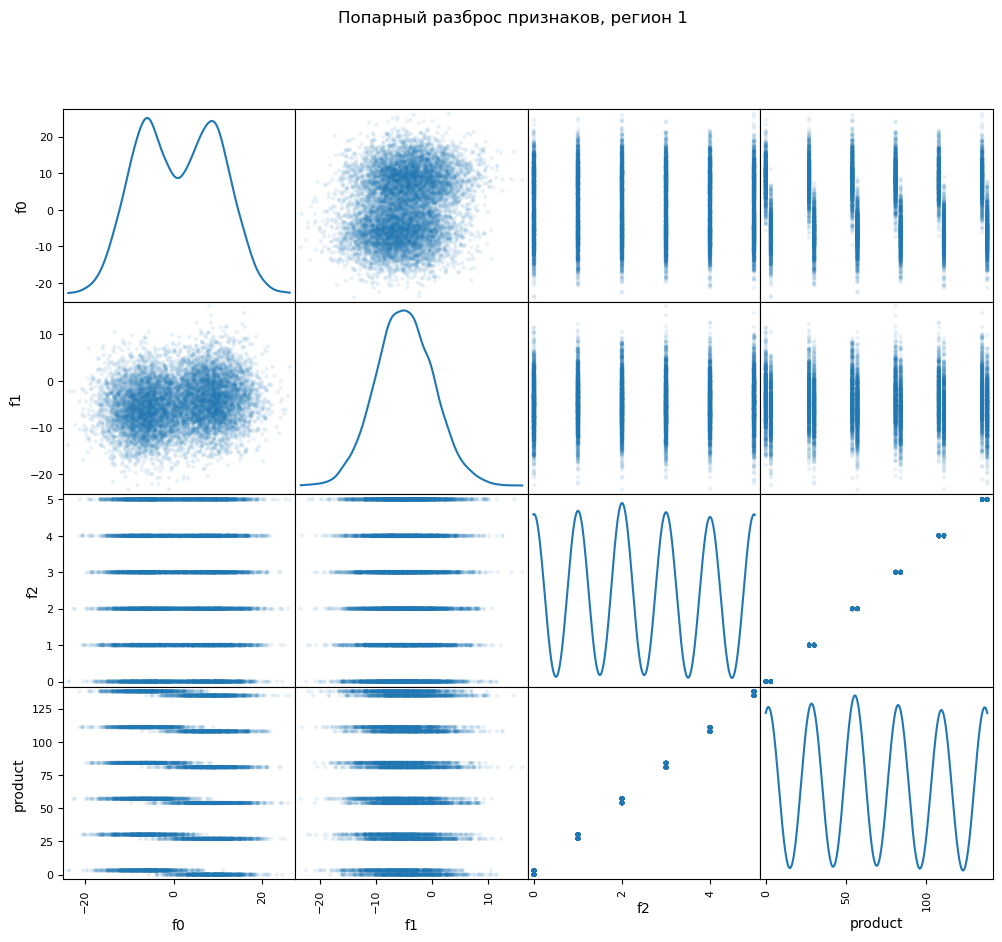

In [17]:
pd.plotting.scatter_matrix(geo_1.sample(frac=0.1), alpha=0.1, figsize=(12, 10), diagonal='kde') 
plt.suptitle('Попарный разброс признаков, регион 1');

Попарная корреляция признаков:

In [18]:
geo_1.drop('id', axis=1).corr().style.background_gradient(cmap='Blues')

,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


### Регион 2, знакомство с данными:

In [19]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [20]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Стандартные статистики:

In [21]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Проверка на полные явные дубликаты строк:

In [22]:
geo_2.duplicated().sum()

0

Проверка на неполные явные дубликаты (по столбцу id):

In [23]:
print('Неполные дубликаты:', geo_2['id'].duplicated().sum())

Неполные дубликаты: 4


Устранение дубликатов (по столбцу id):

In [24]:
geo_2 = geo_2.drop_duplicates(subset=['id'])
print('Неполные дубликаты:', geo_2['id'].duplicated().sum())

Неполные дубликаты: 0


Попарный разброс признаков в регионе 2:

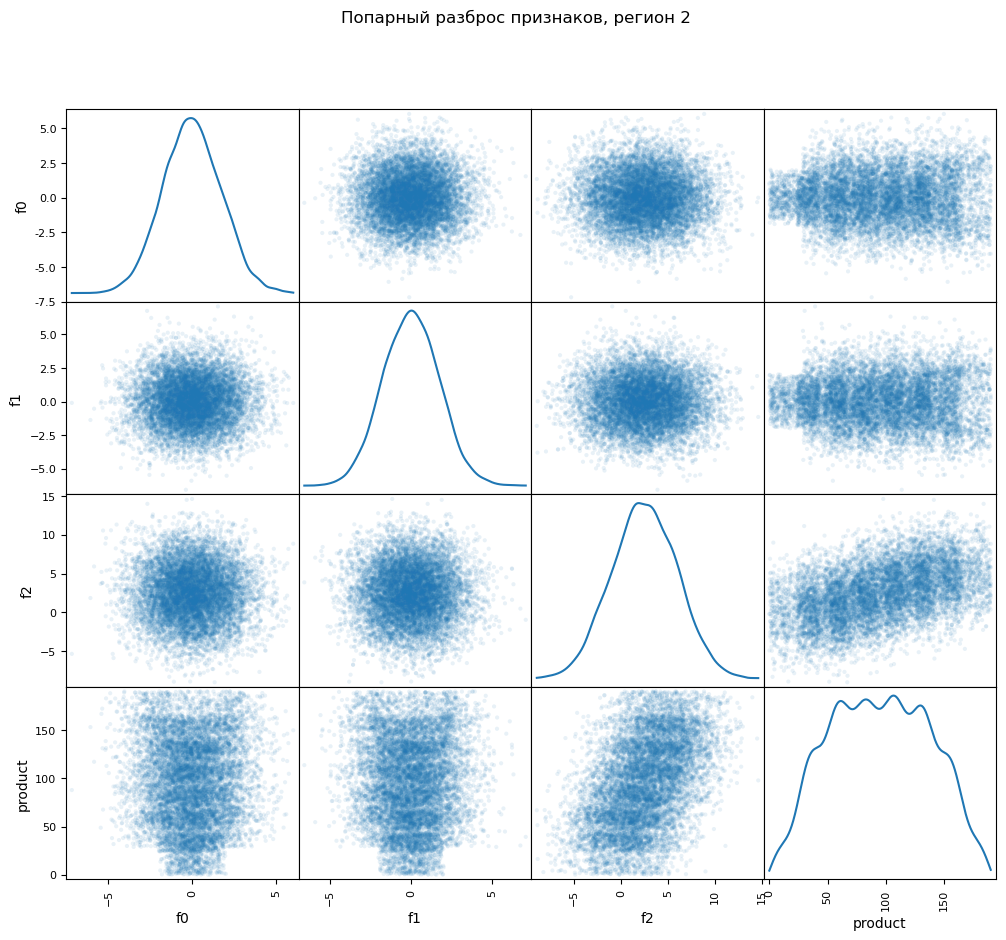

In [25]:
pd.plotting.scatter_matrix(geo_2.sample(frac=0.1), alpha=0.1, figsize=(12, 10), diagonal='kde') 
plt.suptitle('Попарный разброс признаков, регион 2');

Попарная корреляция признаков:

In [26]:
geo_2.drop('id', axis=1).corr().style.background_gradient(cmap='Blues')

,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


 ### Выводы, подготовка данных
 
 - В наборах данных по 100000 строк, пропуски и нетипичные значения отсутствуют.
 - Во всех наборах имелись явные дубликаты в столбце id, которые были удалены.
 - По условию задачи признаки f0, f1, f2 имеют неизвестное смысловое наполнение, поэтому нельзя проверить адекватность значений в этих столбцах.
 - Признак product в 0 регионе имеет разброс значений в диапазоне 0-185,4 тыс. барр.; в регионе 1: 0-137,9 тыс. барр.; в регионе 2: 0-190 тыс. барр.
 - Попарная корреляция признаков говорит о том, что во всех трех наборах данных наибольшая линейная зависимость существует между признаками product и f2, при том в случае с регионом 1 к. корреляции почти равен 1.
 - На парных диаграммах также видна прямая связь между f2 и product во всех наборах данных, особенно явно для региона 1. Также заметно некое подобие квадратичной зависимости между признаками f1 и product в наборе данных для 0-го региона.
 
 Уровень корреляции между признаками f2 и product показывает, что с большей достоверностью линейная модель предскажет величину product на данных региона 1.
 В регионах 0 и 2 больше величина максимальных запасов.

## Обучение и проверка модели

Функция разделения и предобработки данных и функция обучения модели: 

In [27]:
def split_data(dataframe, scaled=True, poly=True, test_size=0.25, random_state=42, poly_degree=4):
    features = dataframe.drop(['id', 'product'], axis=1)
    target = dataframe['product']
    
    features_train, features_val, target_train, target_val = train_test_split(
        features, target, test_size=test_size, random_state=random_state)
    
    fts = [features_train, features_val]
    tgs = [target_train, target_val]
        
        
    if scaled:       # нормализация
        scaler = StandardScaler()      
        scaler.fit(fts[0])
        for f in range(len(fts)):          
            fts[f] = pd.DataFrame(scaler.transform(fts[f]), columns=fts[f].columns, index=fts[f].index)
        
    if poly:         # генерирование новых признаков из-за нелинейности некоторых парных диаграмм распределения
        encoder = PolynomialFeatures(degree=poly_degree)
        encoder.fit(fts[0])
        for f in range(len(fts)):
            fts[f] = pd.DataFrame(encoder.transform(fts[f]),
                                  columns=encoder.get_feature_names_out(), index=fts[f].index)
          
    return fts[0], fts[1], tgs[0], tgs[1]

def train_model(model_name, features_train, features_val, target_train, target_val, plot=True):
    model = model_name()
    model.fit(features_train, target_train)
    pred_val = pd.Series(model.predict(features_val), index=features_val.index)
    mean_reserves = pred_val.mean()
    rmse = mean_squared_error(pred_val, target_val) ** 0.5
    
    if plot:
        plt.figure(figsize = (10, 6))
        plt.hist(pred_val, bins=30)
        plt.axvline(mean_reserves, color='k', linestyle='dashed', linewidth=1)
        plt.xlabel('Тыс. баррелей'); plt.ylabel('Частота')
        plt.title('Распределение предсказанной величины запасов в регионе (val)')
        plt.text(mean_reserves+1, 1000, f'$\mu$ ({mean_reserves:.1f})')
    
    return [model, mean_reserves, rmse, pred_val]

### Регион 0, обучение модели

Средний предсказанный объем нефти в регионе: 92.64 (тыс. барр.)
RMSE: 37.25 (тыс. барр.)


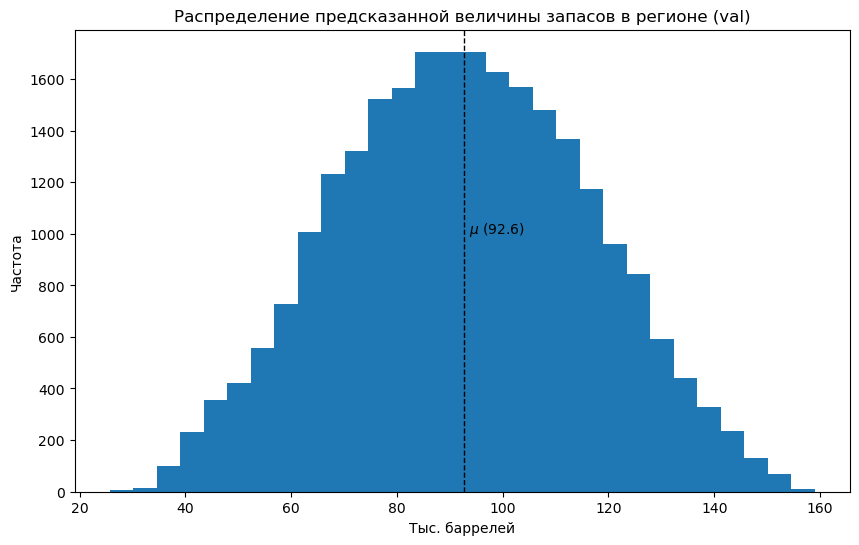

In [28]:
features_train_reg_0, features_val_reg_0, target_train_reg_0, target_val_reg_0 = split_data(geo_0)

lm_reg_0, mean_reg_0, rmse_reg_0, pred_val_reg_0 = train_model(
    LinearRegression, features_train_reg_0, features_val_reg_0, target_train_reg_0, target_val_reg_0)

print(f'Средний предсказанный объем нефти в регионе: {mean_reg_0:.2f} (тыс. барр.)')
print(f'RMSE: {rmse_reg_0:.2f} (тыс. барр.)')

### Регион 1, обучение модели

Средний предсказанный объем нефти в регионе: 68.58 (тыс. барр.)
RMSE: 0.79 (тыс. барр.)


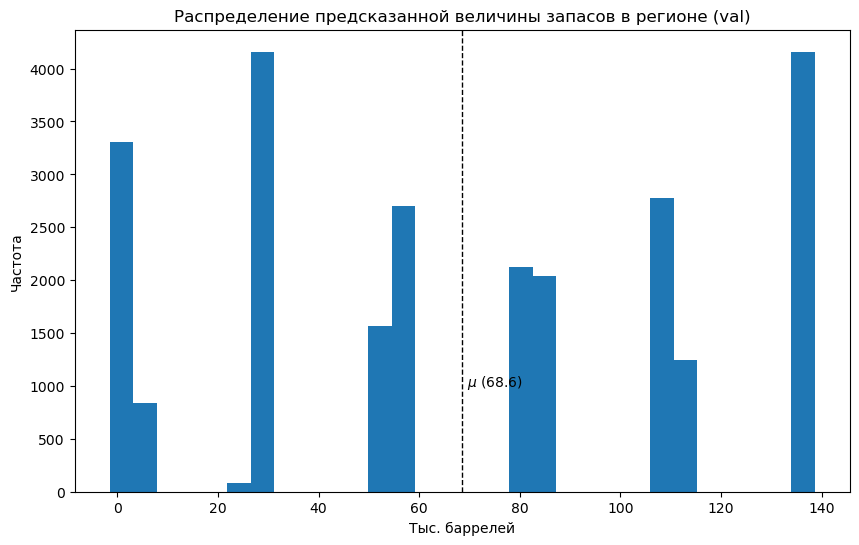

In [29]:
features_train_reg_1, features_val_reg_1, target_train_reg_1, target_val_reg_1 = split_data(geo_1)

lm_reg_1, mean_reg_1, rmse_reg_1, pred_val_reg_1 = train_model(
    LinearRegression, features_train_reg_1, features_val_reg_1, target_train_reg_1, target_val_reg_1)

print(f'Средний предсказанный объем нефти в регионе: {mean_reg_1:.2f} (тыс. барр.)')
print(f'RMSE: {rmse_reg_1:.2f} (тыс. барр.)')

### Регион 2, обучение модели

Средний предсказанный объем нефти в регионе: 94.92 (тыс. барр.)
RMSE: 38.33 (тыс. барр.)


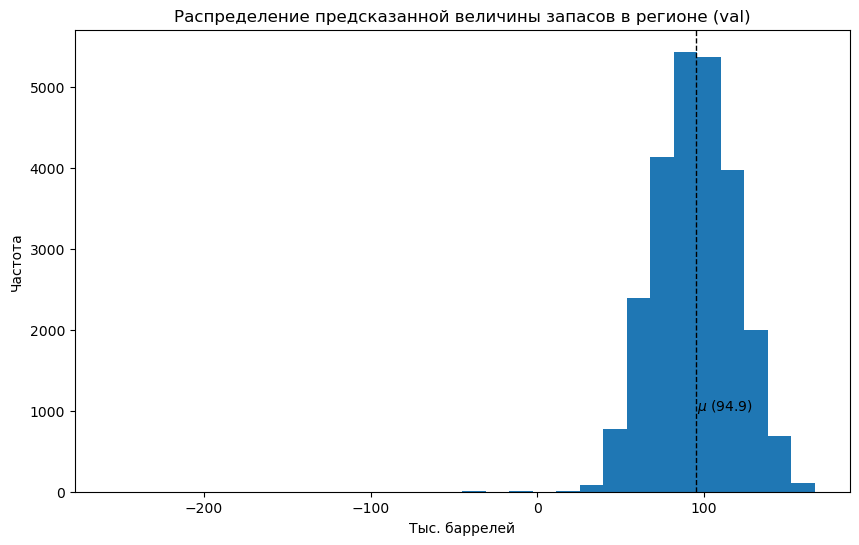

In [30]:
features_train_reg_2, features_val_reg_2, target_train_reg_2, target_val_reg_2 = split_data(geo_2)

lm_reg_2, mean_reg_2, rmse_reg_2, pred_val_reg_2 = train_model(
    LinearRegression, features_train_reg_2, features_val_reg_2, target_train_reg_2, target_val_reg_2)

print(f'Средний предсказанный объем нефти в регионе: {mean_reg_2:.2f} (тыс. барр.)')
print(f'RMSE: {rmse_reg_2:.2f} (тыс. барр.)')

Таблица с результатами:

In [31]:
pd.DataFrame({'Регион':['0', '1', '2'],
              'Средний предсказанный объем нефти':[round(i, 2) for i in [mean_reg_0, mean_reg_1, mean_reg_2]],
              'Средний фактический объем нефти':[round(i, 2) for i in [target_val_reg_0.mean(),
                                                                       target_val_reg_1.mean(),
                                                                       target_val_reg_2.mean()]],
              'RMSE': [round(i, 2) for i in [rmse_reg_0, rmse_reg_1, rmse_reg_2]]}).set_index('Регион')

,Средний предсказанный объем нефти,Средний фактический объем нефти,RMSE
Регион,,,
0,92.64,92.39,37.25
1,68.58,68.58,0.79
2,94.92,95.25,38.33


### Выводы, обучение и проверка моделей
- Данные для каждого региона были разделены на тренировочную и валидационную выборки в соотношении 3:1, затем нормализованы. Так как на парных диаграммах в данных была выявлена нелинейность, были нагенерированы новые признаки с помощью метода PolynomialFeatures.
- По средней величине запасов выделяются регионы 0 и 2 (92,4 и 95,3 тыс. барр. против 68.6 в регионе 1), но в регионе 1, как и ожидалось после исследовательского анализа, ошибка предсказания модели оказалась значительно ниже, чем в других регионах.

## Подготовка и расчет прибыли

Необходимые для расчетов переменные:

In [32]:
sample_places = 500     # всего исследуемых мест для потенцеальных скважин
selected_places = 200   # 200 лучших мест
budget = 10e9           # бюджет на разработку скважины в регионе
unit_income = 450e3     # доход с единицы продукта (с одной тыс. баррелей)

alpha = 5               # %. Уровень значимости доверительного интервала
crit_rate = 2.5         # %. Критический процент убыточности, выше которого разработка месторождений не ведется
bs_repeats = 1000       # количество итераций при bootstrap

# unit_income * volume = avg_profit, безубыточность когда avg_profit == avg_budget
# => volume = avg_budget / unit_income

avg_budget = budget / selected_places    # бюджет на одно выбранное место 
volume = avg_budget / unit_income        # количество тыс. баррелей нефти, необходимой, чтобы окупить бюджет

class bcolors:          # цвета для маркирования превышения порога
    OKGREEN = '\033[92m'   
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'

По валидационной выборке рассчитваю объем для безубыточной добычи и привожу средние запасы нефти по региону для сравнения:

In [33]:
print(f'Объем нефти для безубыточности: {volume:.2f} (тыс. барр.)')
for i, reg in enumerate([target_val_reg_0.mean(),
                         target_val_reg_1.mean(),
                         target_val_reg_2.mean()]):
    print(f'Средний объем нефти в регионе {i}: {reg:.2f} (тыс. барр.)')

Объем нефти для безубыточности: 111.11 (тыс. барр.)
Средний объем нефти в регионе 0: 92.39 (тыс. барр.)
Средний объем нефти в регионе 1: 68.58 (тыс. барр.)
Средний объем нефти в регионе 2: 95.25 (тыс. барр.)


Функция для расчета прибыли:

In [34]:
def get_profit(predicted, target):
    top_places_pred = predicted.sort_values(ascending=False)[:selected_places]
    top_places_actual = target.loc[top_places_pred.index]
    return (top_places_actual.sum() * unit_income - budget) / 1e9 # делю на миллиард, для удобства восприятия

Расчет прибыли:

In [35]:
top_profits = [] # массив прибылей для обращения по индексу
print(f'Прибыль в регионах по лучшим {selected_places} предсказанным моделью месторождениям: \n')
for i, reg in enumerate([(pred_val_reg_0, target_val_reg_0),
                         (pred_val_reg_1, target_val_reg_1),
                         (pred_val_reg_2, target_val_reg_2)]):
    top_profits.append(get_profit(reg[0], reg[1]))
    print(f'Прибыль в регионе {i}: {top_profits[i]:.2f} (миллиарда)')

Прибыль в регионах по лучшим 200 предсказанным моделью месторождениям: 

Прибыль в регионе 0: 3.34 (миллиарда)
Прибыль в регионе 1: 2.42 (миллиарда)
Прибыль в регионе 2: 3.39 (миллиарда)


Таблица с результатами:

In [36]:
tbl_vol_prof = pd.DataFrame({'Регион':['0', '1', '2'],
             'Прибыль на 200 лучших среди предсказанных месторождений': [round(i, 2) for i in top_profits],
             'Среднее предсказанное количество нефти':[round(i, 2) for i in [mean_reg_0, mean_reg_1, mean_reg_2]],
             'Средний объем нефти в регионе':[round(i, 2) for i in [target_val_reg_0.mean(),
                                                                    target_val_reg_1.mean(),
                                                                    target_val_reg_2.mean()]]}).set_index('Регион')
tbl_vol_prof

,Прибыль на 200 лучших среди предсказанных месторождений,Среднее предсказанное количество нефти,Средний объем нефти в регионе
Регион,,,
0,3.34,92.64,92.39
1,2.42,68.58,68.58
2,3.39,94.92,95.25


### Выводы, подготовка к расчету и расчет прибыли

- Рассчитанный уровень безубыточности (111,1 тыс. баррелей) показывает более высокое значение необходимой выработки нефти, чем в среднем имеется в каждом из регионов. Таким образом случайная разработка нефти скорее всего приведет к убыткам, то есть для успешности разработки требуется опираться на аналитику, в том числе на предсказания моделей.
- Если в каждом регионе отобрать 200 лучших месторождений (по предсказанию обученных моделей), то прибыль можно получить в любом регионе, предсказанные значения прибыли сведены в таблицу выше.

## Расчёт прибыли и рисков методом bootstrap

Функции Bootstrap и вывода результатов его работы:

In [37]:
def bootstrap(predicted, target, plot=True):
    profits = []
    losses = []
    for i in range(bs_repeats):    
        sample = predicted.sample(sample_places)
        actual_profit = get_profit(sample, target)
        profits.append(actual_profit)
        if actual_profit < 0:
            losses.append(actual_profit)
    
    cint_l = np.percentile(profits, alpha/2); cint_r = np.percentile(profits, 100-alpha/2) # доверительный интервал
    profits_mean = np.mean(profits)
    money_losses = -sum(losses) / sum(profits) * 100 # доля убытков в общей прибыли
    risks = len(losses) / bs_repeats * 100           # процент убыточных разработок
    
    if plot:
        mu = np.mean(profits)
        plt.figure(figsize=(10, 6))
        plt.hist(profits, bins=30)
        plt.axvline(mu, color='k', linestyle='dashed', linewidth=1)
        plt.xlabel('Миллиарды'); plt.ylabel('Частота')
        plt.title('Распределение средней прибыли (val)')
        plt.plot((cint_l, cint_r), (0.1, 0.1),'|-', color='red', linewidth=2, ms=30)
        plt.text(mu+0.01, 60, f'$\mu$ ({mu:.2f})')
    
    return [profits_mean, money_losses, risks, cint_l, cint_r]

def print_bs(profits_mean, money_losses, risks, cint_l, cint_r):        
    print(f'Средняя прибыль: {profits_mean:.2f} (миллиарда)')
    print(f'Процент денежных потерь в общей прибыли: {money_losses:.2f}%')
    if risks < crit_rate:
        print(f'{bcolors.OKGREEN}Процент убыточных разработок: {risks:.2f}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.FAIL}Процент убыточных разработок: {risks:.2f}%{bcolors.ENDC}')
    print(f'Доверительный интервал: l:{cint_l:.2f}, r:{cint_r:.2f}, ширина: {cint_r-cint_l:.2f} (миллиардов)')

### Регион 0, прибыль и риски (bootstrap):

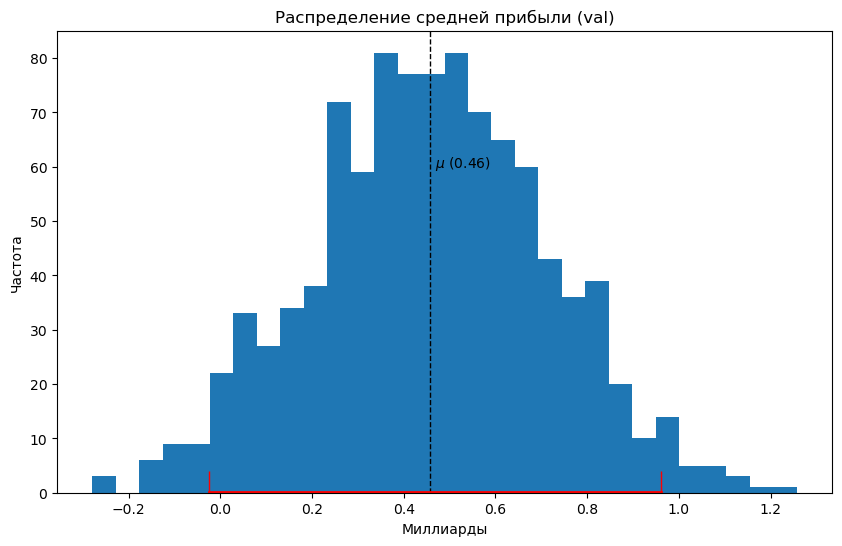

In [38]:
pm_reg_0, ml_reg_0, r_reg_0, c_l_reg_0, c_r_reg_0 = bootstrap(pred_val_reg_0, target_val_reg_0)

In [39]:
print_bs(pm_reg_0, ml_reg_0, r_reg_0, c_l_reg_0, c_r_reg_0)

Средняя прибыль: 0.46 (миллиарда)
Процент денежных потерь в общей прибыли: 0.66%
Процент убыточных разработок: 3.90%
Доверительный интервал: l:-0.03, r:0.96, ширина: 0.99 (миллиардов)


### Регион 1, прибыль и риски (bootstrap):

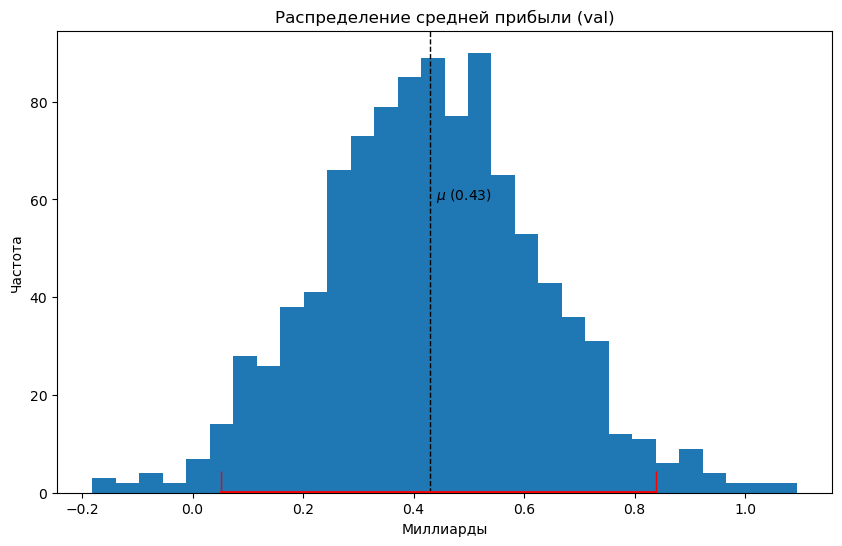

In [40]:
pm_reg_1, ml_reg_1, r_reg_1, c_l_reg_1, c_r_reg_1 = bootstrap(pred_val_reg_1, target_val_reg_1)

In [41]:
print_bs(pm_reg_1, ml_reg_1, r_reg_1, c_l_reg_1, c_r_reg_1)

Средняя прибыль: 0.43 (миллиарда)
Процент денежных потерь в общей прибыли: 0.26%
Процент убыточных разработок: 1.20%
Доверительный интервал: l:0.05, r:0.84, ширина: 0.79 (миллиардов)


### Регион 2, прибыль и риски (bootstrap):

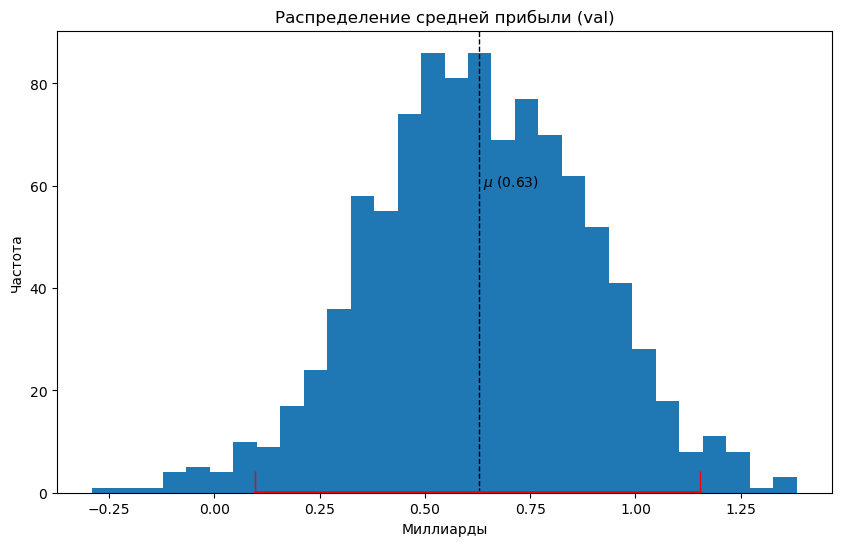

In [42]:
pm_reg_2, ml_reg_2, r_reg_2, c_l_reg_2, c_r_reg_2 = bootstrap(pred_val_reg_2, target_val_reg_2)

In [43]:
print_bs(pm_reg_2, ml_reg_2, r_reg_2, c_l_reg_2, c_r_reg_2)

Средняя прибыль: 0.63 (миллиарда)
Процент денежных потерь в общей прибыли: 0.18%
Процент убыточных разработок: 1.20%
Доверительный интервал: l:0.10, r:1.15, ширина: 1.06 (миллиардов)


Итоговая таблица по методу bootstrap (приводится в Итоговом выводе):

In [44]:
tbl_bootstrap = pd.DataFrame({'Регион':['0', '1', '2'],
'Средняя предсказанная прибыль (млрд.)':[round(i, 2) for i in [pm_reg_0, pm_reg_1, pm_reg_2]],
'Денежные потери (%)': [round(i, 2) for i in [ml_reg_0, ml_reg_1, ml_reg_2]],
'Убыточные разработки (%)': [round(i, 2) for i in [r_reg_0, r_reg_1, r_reg_2]],
'Ширина доверительного интервала (млрд.)':[round(i, 2) for i in [c_r_reg_0-c_l_reg_0, c_r_reg_1-c_l_reg_1, c_r_reg_2-c_l_reg_2]]}
).set_index('Регион')

## Итоговый вывод

Таблица прямой оценки объемов и прибыли линейными моделями:

In [45]:
tbl_vol_prof

,Прибыль на 200 лучших среди предсказанных месторождений,Среднее предсказанное количество нефти,Средний объем нефти в регионе
Регион,,,
0,3.34,92.64,92.39
1,2.42,68.58,68.58
2,3.39,94.92,95.25


Таблица по методу Bootstrap:

In [46]:
tbl_bootstrap

,Средняя предсказанная прибыль (млрд.),Денежные потери (%),Убыточные разработки (%),Ширина доверительного интервала (млрд.)
Регион,,,,
0,0.46,0.66,3.9,0.99
1,0.43,0.26,1.2,0.79
2,0.63,0.18,1.2,1.06


- По результатам применения метода bootstrap видно, что вложения в регионы 1 и 2 удовлетворяют условию по рискам (меньше 2,5% убыточных месторождений)
- Также в регионе 2 самая высокая величина средней прибыли как в случае с прямой оценкой 200 лучших месторождений, предсказанных моделью, так и в случае использования метода bootstrap.

Таким образом можно сказать, что прибыльными являюстя вложения во все три региона, но наиболее прибыльным (среди регионов 0, 1, 2) - вложения в регион 2, где средняя прибыль колеблется в районе 0,64 млрд (а левая граница 95% доверительного интервала 0,11 млрд, что говорит о том. что шанс получить меньше 0,11 млрд прибыли меньше 2,5%).
Так как вложения в разработку нефти в этом регионе ниже порога риска, а прибыль максимальна среди всех регионов, к разработке рекомендуется регион 2.
